In [ ]:
# PROGRESS:

# DONE - Ignore tickers that aren't CAD or USD
# DONE - Purchasing at the closing price of Nov. 25
# DONE - All values should be calculated in CAD
# DONE - Drop any month that does not have at least 18 trading days
# DONE - Minimum 150,000 shares of avg. monthly volume (calculated from Jan 1 to Oct 31)
# DONE - Create DataFrames for closing prices, percent returns, and correlations between 2 stocks
# DONE - Flat fee of $4.95 for each stock purchased in USD and fee paid from $750,000 start (Added to closing prices dataframe)
# DONE - Calculate optimal weightings for 10 stocks
# DONE - Each stock must make up a minimum of (100/2n)% of the portfolio when weighted by value
# DONE - STRATEGY 0
# DONE - STRATEGY 1
# DONE - STRATEGY 3 - CALCULATE CORRELATION BETWEEN STOCK AND MARKET
# (CREATE ORDERED DATAFRAME FOR CORRELATION BETWEEN STOCK AND MARKET (USE S&P 500) AND SELECT TOP 10)
# DONE - STRATEGY 4 - CALCULATE BETA (CREATE ORDERED DATAFRAME OF BETAS OF ALL STOCKS)
# DONE - CALCULATE OVERALL PORTFOLIO FOR STRATEGY 4 (FUNCTION CAN BE REIMPLEMENTED FOR OTHER STRATEGIES)
# $750,000 CAD to spend
# Use closing prices as of November 25, 2023
# DONE - STRATEGY 5 - COMBINE 3 AND 4 (USE BETA TO REORDER STOCKS BEFORE WEIGHTINGS APPLIED)

# TO-DOS:

# JOHNSON
# STRATEGY 2 - DYNAMIC PROGRAMMING
# IN PROGRESS - DOCUMENTATION

# BODHANA
# IN PROGRESS - DOCUMENTATION

# ASHTON
# IN PROGRESS - DOCUMENTATION

In [ ]:
# REMOVE THIS BEFORE SUBMISSION
!pip install yfinance
!pip install numpy-financial

In [ ]:
# REMOVE THIS BEFORE SUBMISSION
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**GROUP ASSIGNMENT**
### Team Number: 7
### Team Member Names: Ashton, Bodhana, Johnson
### Team Strategy Chosen: RISKY

In [ ]:
# IMPORT NECESSARY LIBRARIES
from IPython.display import display, Math, Latex
import pandas as pd
import yfinance as yf
import numpy as np
import numpy_financial as npf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from datetime import datetime

##**SUMMARY OF OVERALL STRATEGY**

**Please add/edit as you wish, I was just brainstorming**

The strategy for our portfolio is risky, where we're aiming for the highest "ending value", or in other words, the highest percent returns on our initial investment.

As a result, we are ignoring any strategies involving diversification, and instead, are focusing on strategies that obtain the most volatile stocks, in order to maximize movement during the short time period in which the performance of the portfolio is being measured.

First of all, to minimize any type of diversification, we will be selecting the minimium number of stocks allowed for the assignment, which is 10. This ensures that we are not diversifying away any type of non-systematic risk relating to a specific firm, as we want to maximuze our bias towards a specific stock or industry.

We are going to be selecting our 10 stocks based on a combination of two factors, correlation and beta. Ideally, we want our portfolio to consist of 10 stocks that have perfect correlation to each other, as we do not want any stocks moving in opposite directions, which supports a diversified, risk-adverse portfolio. In addition, we want our 10 stocks to be volatile relative to the overall market. Thus, we want to prioritize the stocks with a higher beta value in our portfolios. Further details about how we're using correlation and beta will be outlined in our strategies.

##**GLOBAL CONSTANTS**

We start by setting our global constants, including the CSV file of tickers we will be reading, the start and end of the interval we will be analyzing to make our decisions, the date we will be purchasing stocks for the simulation, our investment amount, the number of stocks we will purchase, and flat fee amount that will be applied to every purchased stock.

In [ ]:
# Ticker CSV file
# CHANGE TO ONE VARIABLE BEFORE SUBMITTING - file_name = "Tickers_Example.csv"
ticker_file_name = '/content/drive/MyDrive/Tickers_Example.csv'

# Start date (starting from year after COVID-19 pandemic since most reflective of current economic situation)
start_date = '2022-01-04'

# End date
# SOURCE: https://stackoverflow.com/questions/57365072/get-todays-date-in-pandas
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

# Date of simulation - EDIT IN PORTFOLIO GENERATION FUNCTION BEFORE SUBMITTING
simul_date = '2023-11-25'

# Flat fee of $4.95 CAD
flat_fee = 4.95

# Number of stocks we are choosing
num_stocks = 10

# Investment amount in CAD
investment = 750000

##**PROCESSING TICKERS**

We then generate a list of the tickers from the CSV file.

In [ ]:
# Get list of tickers from the file
raw_tickers = pd.read_csv(ticker_file_name, header = None)[0].tolist()
print(raw_tickers)

['AAPL', 'ABBV', 'ABT', 'ACN', 'AGN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CELG', 'CL', 'KO', 'LLY', 'LMT', 'MO', 'MON', 'MRK', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RTN', 'RY.TO', 'SHOP.TO', 'T.TO', 'TD.TO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB']


With the given list of raw tickers, we filter the tickers based on the given requirements:

* Ignore any tickers that do not reference a valid stock denominated in either USD or CAD.
* Only include stocks in your portfolio that have at least 150,000 shares of average monthly volume, as calculated based on the time interval of January 1, 2023 to October 31, 2023.
* Drop any month that does not have at least 18 trading days.


In [ ]:
# FILTER A TICKER FILE AND CREATE A LIST OF THE VALID STOCKS

# Start and end dates used for the filter calculations
required_start_for_filter = "2023-01-01"
required_end_for_filter = "2023-10-01"

# Minimum trading days and volume
minimum_days = 18
minimum_avg_volume = 150000

# List of valid exchange tickers
valid_us_exchanges = ['NMS', 'BTS', 'IEX', 'NAS', 'ASE', 'PCX', 'NYQ', 'OPR', 'OBB', 'PNK']
valid_can_exchanges = ['CSE', 'NEO', 'TOR', 'VAN']

# Empty list to store the valid tickers
valid_tickers = []

# Consumes a stock ticker and checks whether it is a valid stock based on assignment rules
def validate_stock(stock):

    stock_info = yf.Ticker(stock).fast_info

    # Accomodate for any tickers that give an error
    try:

        # First, check if the stock is denominated in USD or CAD and is trading on a valid exchange
        if ((stock_info['currency'] == 'USD' or stock_info['currency'] == 'CAD') and
            (stock_info['exchange'] in valid_us_exchanges or stock_info['exchange'] in valid_can_exchanges)):

            # Get the stock's history data
            stock_hist = yf.Ticker(stock).history(start=required_start_for_filter, end=required_end_for_filter).dropna()

            # Create a dataframe of the number of trading days per month
            monthly_trading_days = stock_hist['Volume'].groupby(pd.Grouper(freq = 'MS')).count()

            # Create a dataframe of the stock's total monthly volume
            monthly_volume = stock_hist['Volume'].groupby(pd.Grouper(freq = 'MS')).sum()

            # Drop the months in the volumes which has less than the minimum amount of trading days
            for month in monthly_trading_days.index:

                num_of_days = monthly_trading_days.loc[month]

                if num_of_days < minimum_days:
                    monthly_volume.drop(month, inplace = True)

            # If the monthly volume requirement is met, add it to the list
            if monthly_volume.mean() >= minimum_avg_volume:
                valid_tickers.append(stock)

            else:
                print(f"{stock} did not meet the volume requirements.")

        else:
            print(f"{stock} is not in a Canadian or U.S. stock market.")

    except:
        print(f"{stock} is not valid.")

for ticker in raw_tickers:
    validate_stock(ticker)

print(f'List of valid tickers: {valid_tickers}')

AGN is not valid.
CELG is not valid.
MON is not valid.
RTN is not valid.
List of valid tickers: ['AAPL', 'ABBV', 'ABT', 'ACN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CL', 'KO', 'LLY', 'LMT', 'MO', 'MRK', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RY.TO', 'SHOP.TO', 'T.TO', 'TD.TO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB']


##**PROCESSING CLOSE PRICES**

Below, we create a dataframe of each stock's closing prices and adjust the stock values accordingly to CAD if they are originally denoted in USD.

In [ ]:
# CREATE DATAFRAME OF CLOSE PRICES

# Consumes a list of stocks and empty dataframe, and produces a dataframe of the stocks' closing prices
def add_close_prices(valid_tickers, close_price_data):

    for ticker in valid_tickers:
      close_price_data[ticker] = yf.Ticker(ticker).history(start = start_date, end = end_date, interval = '1d')['Close']

    return close_price_data

In [ ]:
# CONVERT USD TO CAD IN CLOSE PRICE DATAFRAME

# Get USD-CAD exchange data
exchange_close_data = pd.DataFrame(yf.Ticker("USDCAD=x").history(start = start_date, end = end_date, interval = '1d')['Close'])

# SOURCE: https://www.geeksforgeeks.org/how-to-rename-columns-in-pandas-dataframe/
exchange_close_data.rename(columns = {'Close':'1 USD = ? CAD'}, inplace = True)

# Remove timestamp from indices
exchange_close_data.index = exchange_close_data.index.strftime('%Y-%m-%d')

def convert_USDtoCAD(close_price_data, exchange_close_data):

    # Check if the stock is in USD or CAD
    for col in close_price_data.columns:

        stock_info = yf.Ticker(col).fast_info

        # Convert USD to CAD
        if (stock_info['currency'] == 'USD'):
            close_price_data[col] = close_price_data[col] * exchange_close_data['1 USD = ? CAD']

    return close_price_data

In [ ]:
# CREATE DATAFRAME OF ADJUSTED CLOSE PRICES

def create_close_price_dataframe(valid_tickers, exchange_close_data):

    # Create dataframe
    close_price_data = pd.DataFrame()

    # Add raw closing prices
    close_price_data = add_close_prices(valid_tickers, close_price_data)

    # Remove timestamp from indices
    close_price_data.index = close_price_data.index.strftime('%Y-%m-%d')

    # Extract exchange data for ONLY trading days
    # SOURCE: https://stackoverflow.com/questions/61954359/pandas-delete-rows-in-a-dataframe-that-are-not-in-another-dataframe
    exchange_close_data = exchange_close_data[exchange_close_data.index.isin(close_price_data.index)]

    # Convert USD stocks to CAD
    convert_USDtoCAD(close_price_data, exchange_close_data)

    return close_price_data

In [ ]:
close_price_data = create_close_price_dataframe(valid_tickers, exchange_close_data)
close_price_data

,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,QCOM,RY.TO,SHOP.TO,T.TO,TD.TO,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-04,226.552331,159.442504,166.927881,500.642443,72.157410,213.612338,215.355757,272.406035,58.458197,308.237178,...,229.053365,126.313423,155.223007,27.261301,92.310951,229.406003,610.956600,308.201552,257.939859,68.905421
2022-01-05,219.714973,159.690502,165.566694,490.016781,70.905012,208.805697,212.277250,270.692656,57.260121,303.978180,...,227.321135,127.679581,151.345001,27.261301,92.868446,223.794547,607.209015,307.993899,253.762322,68.289847
2022-01-06,216.994409,159.635172,166.267947,468.398370,72.439738,208.313740,215.161682,269.671956,58.669193,302.797186,...,227.644447,129.054947,148.746994,27.297943,93.435219,224.703526,584.912907,310.200890,257.345753,70.454753
2022-01-07,216.699900,158.848914,166.393892,458.338026,74.162527,206.934499,216.494989,274.335816,59.808646,296.104467,...,220.344721,130.845718,144.617996,27.169701,93.875839,215.390459,569.812708,311.048893,258.544101,71.401664
2022-01-10,215.306918,159.576158,164.939233,458.102242,74.489946,204.229726,214.288987,264.712270,59.115247,297.594211,...,218.017137,131.565704,143.389008,27.004812,93.491470,218.178658,573.984099,303.555656,249.281897,71.353072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17,260.863597,190.191554,136.902164,450.835091,88.673548,199.652985,223.554142,286.098689,41.228797,313.547891,...,178.048446,120.489998,93.870003,24.219999,84.779999,212.634971,737.511366,301.459804,203.503577,51.762905
2023-11-20,262.650244,189.747480,138.836272,453.961689,88.295482,200.475748,224.785817,298.676350,41.170718,315.687901,...,177.674757,120.529999,95.449997,24.200001,85.099998,213.385311,734.103636,303.327090,205.195087,51.624597
2023-11-21,261.636253,190.394442,139.862314,453.252159,89.165483,197.489799,222.728419,299.555949,40.705682,315.064187,...,174.323521,119.779999,95.540001,24.100000,84.220001,210.568865,740.538781,304.675033,205.545860,50.792894


##**PROCESSING PERCENT RETURNS**

Using the closing prices obtained from above, we then calculate the day-to-day percentage returns. We will be using this data in the calculations for our strategies.

In [ ]:
# CREATE DATAFRAME OF PERCENT RETURNS

def create_stock_return_dataframe(close_price_data):

  # Create dataframe
  stock_return_data = pd.DataFrame()

  for stock in close_price_data.columns:

      # Get percent return of stock and add to dataframe
      stock_return_data[stock] = close_price_data[stock].pct_change()

  # Drop day one
  stock_return_data.drop(index = stock_return_data.index[0], inplace = True)

  return stock_return_data

In [ ]:
stock_return_data = create_stock_return_dataframe(close_price_data)
stock_return_data

,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,QCOM,RY.TO,SHOP.TO,T.TO,TD.TO,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-05,-0.030180,0.001555,-0.008154,-0.021224,-0.017356,-0.022502,-0.014295,-0.006290,-0.020495,-0.013817,...,-0.007563,0.010816,-0.024983,0.000000,0.006039,-0.024461,-0.006134,-0.000674,-0.016196,-0.008934
2022-01-06,-0.012382,-0.000346,0.004235,-0.044118,0.021645,-0.002356,0.013588,-0.003771,0.024608,-0.003885,...,0.001422,0.010772,-0.017166,0.001344,0.006103,0.004062,-0.036719,0.007166,0.014121,0.031702
2022-01-07,-0.001357,-0.004925,0.000757,-0.021478,0.023782,-0.006621,0.006197,0.017295,0.019422,-0.022103,...,-0.032066,0.013876,-0.027759,-0.004698,0.004716,-0.041446,-0.025816,0.002734,0.004657,0.013440
2022-01-10,-0.006428,0.004578,-0.008742,-0.000514,0.004415,-0.013071,-0.010190,-0.035079,-0.011594,0.005031,...,-0.010563,0.005503,-0.008498,-0.006069,-0.004094,0.012945,0.007321,-0.024090,-0.035824,-0.000681
2022-01-11,0.018239,0.005690,0.004689,0.007096,0.007302,0.025468,0.010884,0.033535,0.007162,0.027860,...,0.033311,0.008840,0.015957,0.004749,0.009225,0.010627,0.010046,-0.014014,-0.000745,0.013835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17,0.004915,0.005166,-0.002096,0.006587,0.010663,0.021556,0.027200,0.012026,0.019990,-0.001374,...,0.011034,0.006095,0.012731,-0.003702,0.011694,0.023084,-0.001551,0.004333,0.012341,0.013638
2023-11-20,0.006849,-0.002335,0.014128,0.006935,-0.004264,0.004121,0.005510,0.043963,-0.001409,0.006825,...,-0.002099,0.000332,0.016832,-0.000826,0.003774,0.003529,-0.004621,0.006194,0.008312,-0.002672
2023-11-21,-0.003861,0.003410,0.007390,-0.001563,0.009853,-0.014894,-0.009153,0.002945,-0.011295,-0.001976,...,-0.018862,-0.006223,0.000943,-0.004132,-0.010341,-0.013199,0.008766,0.004444,0.001709,-0.016111


##**OPTIMAL WEIGHTINGS**

We first considered using the [HRPOpt method](https://builtin.com/data-science/portfolio-optimization-python) from Pypfopt to optimize the weightings based on past stock performance. However, the requirements to cap a stock at 25% of the portfolio and have a minimum of 100/2n where n is the number of stocks (n = 10) could not be accomodated for using the built-in function.

As a result, we started from first principles and determined that in order to maximize volatility, we should maximize the amount invested into the most volatile stock and progress down the list. After consulting with past CFM 101 students, we arrived at the following code to calculate our weights.

In [ ]:
# CALCULATE OPTIMAL WEIGHTINGS

stocks_left = num_stocks

max_weight = 25
min_weight = 100 / (2 * num_stocks)
total_weight = 0

optimal_weights_lst = []

while (stocks_left != 0):

  # Weight of next stock on list
  next_weight = min_weight * (stocks_left - 1)
  rem_weight = 100 - next_weight - total_weight

  if (rem_weight > max_weight):
    optimal_weights_lst.append(max_weight / 100)
    total_weight += max_weight

  elif (rem_weight > min_weight):
    optimal_weights_lst.append(rem_weight / 100)
    total_weight += rem_weight

  else: # rem_weight <= min_weight
    optimal_weights_lst.append(min_weight / 100)
    total_weight += min_weight

  stocks_left -= 1

optimal_weights_lst

[0.25, 0.25, 0.15, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

##**STRATEGY 0**

To select the 10 most volatile stocks, a brute force solution is not possible. The number of possibilities would be x choose 10 with x being the number of candidate stocks. For example, even a relatively small x-value of 50 would lead to the number of possibilities spanning over 12 billion stock combinations. This is O(n^(x-10)) time complexity, reasonable with a dedicated computer for running the calculations but impractical for the purposes of this assignment.
Even looping from 0 to 12 billion took Python too long.

We hence shifted our focus to finding a heuristic solution or a strategy not guaranteed to find the optimal solution but a satisfactory one in a reasonable amount of time.


##**STRATEGY 1**

This strategy is built on the assumption that given Stock A, all other stocks that demonstrate a high correlation to Stock A have a high correlation amongst themselves.

We consider this to be a fair assumption. In an ideal world, we would invest in a singular stock, but that is not possible based on the requierements for this assignment. Thus, we want all 10 of our stocks to be very similar to carbon copies of each other. In this scenario, once we select one of the stocks, then create a portfolio with the other stock, since they are carbon copies, the portfolio will not change. To reiterate, comparing the third carbon copy stock and so on would not result in a change.

We do recognize the stocks may be inversely correlated to one another and hence the bottom 10 stocks could may consist a riskier portfolio However, the probability of this occurring is slim and hence an assumption has been made to omit the redundant implementation.

In [ ]:
# CREATE A CORRELATIONS MATRIX (DATAFRAME OF CORRELATIONS BETWEEN TWO STOCKS)

def create_stock_correl_dataframe(stock_return_data):

  correl_data = pd.DataFrame()

  # Calculate correlation using the pearson method
  # SOURCE: https://www.geeksforgeeks.org/python-pandas-dataframe-corr/
  correl_data = stock_return_data.corr(method = "pearson")

  return correl_data

Here is the correlation matrix of each stock provided.

In [ ]:
stock_correl_data = create_stock_correl_dataframe(stock_return_data)
stock_correl_data

,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,QCOM,RY.TO,SHOP.TO,T.TO,TD.TO,TXN,UNH,UNP,UPS,USB
AAPL,1.000000,0.216510,0.542476,0.720990,0.492164,0.634685,0.605321,0.499426,0.485297,0.332625,...,0.700248,0.341143,0.480866,0.314911,0.354303,0.698717,0.409927,0.454568,0.539057,0.381866
ABBV,0.216510,1.000000,0.406709,0.281710,0.302808,0.125727,0.235176,0.183340,0.276082,0.260876,...,0.165492,0.144670,0.026886,0.183547,0.175600,0.253866,0.454947,0.250491,0.249320,0.285757
ABT,0.542476,0.406709,1.000000,0.553082,0.452432,0.427039,0.481152,0.411094,0.485738,0.328722,...,0.460929,0.336174,0.307481,0.324082,0.334980,0.480487,0.404009,0.443173,0.453893,0.403314
ACN,0.720990,0.281710,0.553082,1.000000,0.515552,0.619378,0.607809,0.485217,0.522824,0.374259,...,0.644642,0.384035,0.444206,0.340581,0.386156,0.692981,0.393076,0.494315,0.566135,0.468573
AIG,0.492164,0.302808,0.452432,0.515552,1.000000,0.369103,0.654842,0.491377,0.701796,0.282077,...,0.467705,0.511820,0.270850,0.282937,0.529791,0.437187,0.368930,0.451775,0.458710,0.691669
AMZN,0.634685,0.125727,0.427039,0.619378,0.369103,1.000000,0.509829,0.436081,0.447381,0.298495,...,0.572888,0.323000,0.555956,0.256729,0.323279,0.560245,0.222848,0.361637,0.491722,0.309943
AXP,0.605321,0.235176,0.481152,0.607809,0.654842,0.509829,1.000000,0.534569,0.691800,0.330785,...,0.557509,0.476918,0.396525,0.325174,0.532237,0.542649,0.335182,0.434327,0.534780,0.613364
BA,0.499426,0.183340,0.411094,0.485217,0.491377,0.436081,0.534569,1.000000,0.493292,0.306175,...,0.466605,0.306767,0.390412,0.197539,0.351215,0.465960,0.255703,0.411381,0.416349,0.401499
BAC,0.485297,0.276082,0.485738,0.522824,0.701796,0.447381,0.691800,0.493292,1.000000,0.314659,...,0.487311,0.581164,0.370798,0.298153,0.607617,0.495110,0.350411,0.487508,0.543100,0.723852
BIIB,0.332625,0.260876,0.328722,0.374259,0.282077,0.298495,0.330785,0.306175,0.314659,1.000000,...,0.288708,0.232766,0.238367,0.245568,0.202496,0.362857,0.311690,0.283638,0.305766,0.262361


In [ ]:
# STRATEGY 1

# Select set of 9 stocks that is best correlated to a singular stock

max_sum = 0
top10_dict = {}

for stock in stock_correl_data.columns:

  # Subtract one to get rid of the one value with itself
  current_col_sum = stock_correl_data[stock].nlargest(10).sum() - 1

  if current_col_sum > max_sum:
    max_sum = current_col_sum
    top10_dict = stock_correl_data[stock].nlargest(10)

top10_df = pd.DataFrame(top10_dict.items(), columns = ["Ticker", "Correlation"])

Here are the 9 stocks that possesses the highest average correlation to a singular stock:

In [ ]:
display(top10_df)

,Ticker,Correlation
0,BAC,1.000000
1,C,0.824880
2,BK,0.769155
3,USB,0.723852
4,AIG,0.701796
5,BLK,0.699242
6,AXP,0.691800
7,TD.TO,0.607617
8,RY.TO,0.581164
9,UPS,0.543100


Thus, here are the final 10 stocks obtained from Strategy 1:

In [ ]:
# FINAL TICKERS FROM STRATEGY / PORTFOLIO 1
p1_tickers = list(top10_df["Ticker"])
p1_tickers

['BAC', 'C', 'BK', 'USB', 'AIG', 'BLK', 'AXP', 'TD.TO', 'RY.TO', 'UPS']

##**STRATEGY 2**
This strategy uses dynamic programming.
The subproblem is finding the stock that correlates the most to the current portfolio, adding that stock to the portfolio and then finding the next stock.

In theory, this does not work on all data sets, because it is possible for the algorithm to get trapped in a local minimum. For example, if there were 5 stocks, where two of them are very closely correlated and the three other stocks were not too closely correlated such that it would dodge the first selection but all three of them are much more correlated than just the two closely correlated stocks and a third non correlated stock.

However, despite this obvious limitation, we thought that this would be a reasonable approach because in the real world, the stocks should be a bit more random, so it would be unlikely that we would have only a single pair of closely correlated stocks with the rest of them being completely opposite.

This algorithm did not generate the most volatile portfolio. Though, this algorithm could be interesting to use when the program is scaled up. The time complexity of this is still O(n^2) so this is a computational viable option if there were perhaps hundreds of stocks.

In [ ]:
# BRAINSTORM

# Find the pair with the highest correlation
# Combine the pair into one portfolio
# Find the next stock, by taking the one with the most correlation to the portfolio

#First find the first pair
max_corr = 0
pair = []
stockPortfolio = pd.DataFrame()

for stock in stock_correl_data.columns:
  # Subtract one to get rid of the one value with itself
  current_col_sum = stock_correl_data[stock].nlargest(2).sum() - 1
  if current_col_sum > max_corr:
    max_corr = current_col_sum
    pair = [stock, stock_correl_data[stock].nlargest(2).index[1]]
print(max_corr)
print(pair)
stocks = stock_return_data
#average percent returns
startingPortfolio = stocks[pair[0]]*0.5 + stocks[pair[1]] * 0.5
curAssetDict = {}
curAssetDict[pair[0]] = True
curAssetDict[pair[1]] = True

def findMax(stocks, curPortfolio, numAssets, curAssetDict):
  if numAssets == 10:
    return curPortfolio
  runningMax = 0
  maxCandidate = pd.DataFrame()
  #Find stock with greatest correlation to portfolio
  for stock in stock_return_data.columns:
    if stock in curAssetDict:
      continue

    correlation = stock_return_data[stock].corr(curPortfolio)
    if correlation > runningMax:
      runningMax = correlation
      maxCandidate = stock_return_data[stock]
  #create new equally weighted portfolio
  curPortfolio = curPortfolio*(numAssets / (numAssets+1)) + (1/(numAssets+1))*maxCandidate
  #print(maxCandidate)
  curAssetDict[maxCandidate.name] = True
  return findMax(stocks,curPortfolio, numAssets + 1, curAssetDict)

findMax(stocks, startingPortfolio, 2, curAssetDict)
print(curAssetDict)

p2_tickers = list(curAssetDict)


0.8426359450132743
['KO', 'PEP']
{'KO': True, 'PEP': True, 'PG': True, 'CL': True, 'ABT': True, 'UNH': True, 'MRK': True, 'ABBV': True, 'PM': True, 'PFE': True}


Here are the final 10 stocks obtained from Strategy 2:

In [ ]:
# FINAL TICKERS FROM STRATEGY 2
p2_tickers = list(curAssetDict)
p2_tickers

['KO', 'PEP', 'PG', 'CL', 'ABT', 'UNH', 'MRK', 'ABBV', 'PM', 'PFE']

##**STRATEGY 3**

Correlation between each stock and the S&P500

In [ ]:
# STRATEGY 3

# Create dataframe of chosen market's returns

def create_market_return_dataframe(m_index):

  # Create dataframe
  market_return_data = m_index.history(start = start_date, end = end_date, interval = '1d')['Close'].pct_change()

  #R emove timestamp from indices
  market_return_data.index = market_return_data.index.strftime('%Y-%m-%d')

  # Drop day one
  market_return_data.drop(index = market_return_data.index[0], inplace = True)

  return market_return_data

# Create dataframe of correlation between each stock and the chosen market

def create_market_correl_dataframe(market_return_data, stock_return_data):

  market_correl_data = pd.DataFrame({"Ticker": stock_return_data.columns})
  corr_list = []

  for col in stock_return_data.columns:

    corr_list.append(stock_return_data[col].corr(market_return_data))

  market_correl_data["Correlation"]  = corr_list
  market_correl_data.sort_values(by = ['Correlation'], ascending = False, ignore_index = True, inplace = True)

  return market_correl_data

In [ ]:
# Selected S&P500 as our market index
sp500 = yf.Ticker('^GSPC')
market_return_data = create_market_return_dataframe(sp500)
market_correl_data = create_market_correl_dataframe(market_return_data, stock_return_data)

top10_df2 = market_correl_data.head(10)
top10_df2

,Ticker,Correlation
0,AAPL,0.821321
1,BLK,0.803845
2,ACN,0.799809
3,TXN,0.745828
4,AMZN,0.735144
5,QCOM,0.725018
6,AXP,0.702923
7,BAC,0.661269
8,BK,0.649334
9,UPS,0.648137


Here are the final 10 stocks obtained from Strategy 3:

In [ ]:
# FINAL TICKERS FROM STRATEGY / PORTFOLIO 3
p3_tickers = list(top10_df2["Ticker"])
p3_tickers

['AAPL', 'BLK', 'ACN', 'TXN', 'AMZN', 'QCOM', 'AXP', 'BAC', 'BK', 'UPS']

##**STRATEGY 4**

For our fourth strategy, we'll be using a common statistical measure of risk in the stock market, namely beta. In short, beta is a measure of volatility, and it specifically measures the conditional risk of a securitiy's returns in relation to the overall market. Stocks with a beta greater than 1 are more volatile than the market its being measured against. Since we are trying to maximize volatility in our portfolio, we'll start off by creating a portfolio that finds the stocks with the greatest beta.

Correlation measures the tendency of two data sets to move in the same direction, but it does not account for the relative size of those directional moves. Beta, on the other hand, accounts for both direction and relative volatility and can therefore be more insightful when comparing the return streams of two investments1. Based on the formula, Beta = correlation (between sector and market) x volatilit

\begin{align*}
\beta=\frac{COV(x_i,r_M)}{\sigma^2(r_M)}
\end{align*}

In [ ]:
# STRATEGY 4

# Create dataframe of beta of each stock in relation to the chosen market

def create_beta_dataframe(market_return_data, stock_return_data):

  market_var = market_return_data.var()
  beta_data = pd.DataFrame({"Ticker": stock_return_data.columns})
  beta_list = []

  for col in stock_return_data.columns:

    beta_list.append((stock_return_data[col].cov(market_return_data)) / market_var)

  beta_data["Beta"]  = beta_list
  beta_data.sort_values(by = ['Beta'], ascending = False, ignore_index = True, inplace = True)

  return beta_data

In [ ]:
beta_data = create_beta_dataframe(market_return_data, stock_return_data)

top10_df3 = beta_data.head(10)
top10_df3

,Ticker,Beta
0,SHOP.TO,2.285797
1,AMZN,1.625729
2,PYPL,1.598603
3,QCOM,1.514591
4,BLK,1.275988
5,AAPL,1.268462
6,ACN,1.185571
7,BA,1.168665
8,AXP,1.136349
9,TXN,1.116555


Here are the final 10 stocks obtained from Strategy 4:

In [ ]:
# FINAL TICKERS FROM STRATEGY / PORTFOLIO 4
p4_tickers = list(top10_df3["Ticker"])
p4_tickers

['SHOP.TO', 'AMZN', 'PYPL', 'QCOM', 'BLK', 'AAPL', 'ACN', 'BA', 'AXP', 'TXN']

##**STRATEGY 5**

This strategy takes Strategy 3, where we found the 10 most correlated stocks to the S&P 500, and combines it with Strategy 4, where we found the 10 stocks with the highest beta. Ensuring that the stocks are correlated with the S&P 500 and is weighted by its volatility via beta will create a portfolio that not only moves identically, but will account for directional movements in terms of volatility.

In [ ]:
# STRATEGY 5

# Get the return data of the 10 most correlated stocks from Strategy 3
# Calculate their betas and order them from greatest to least
correlated_stocks_w_beta = create_beta_dataframe(market_return_data, create_stock_return_dataframe(create_close_price_dataframe(p3_tickers, exchange_close_data)))

correlated_stocks_w_beta

,Ticker,Beta
0,AMZN,1.625729
1,QCOM,1.514591
2,BLK,1.275988
3,AAPL,1.268461
4,ACN,1.185570
5,AXP,1.136349
6,TXN,1.116555
7,BAC,1.003867
8,BK,0.962078
9,UPS,0.938861


Here are the final 10 stocks obtained from Strategy 5:

In [ ]:
p5_tickers = correlated_stocks_w_beta.Ticker.tolist()
print(p5_tickers)

['AMZN', 'QCOM', 'BLK', 'AAPL', 'ACN', 'AXP', 'TXN', 'BAC', 'BK', 'UPS']


##**PORTFOLIO GENERATION**

Below, we create a function that will generate a portfolio given a list of tickers, and our investment amount. This function will also accomodate for the flat fees that are applied to a stock purchase, which in this case will be $4.95.

In [ ]:
def generate_portfolio(tickers, investment):

  portfolio = pd.DataFrame()

  shares_in_each = []
  price_of_each = []
  investment_lst = []
  currency_lst = []

  for i in range(len(tickers)):

    stock_info = yf.Ticker(tickers[i]).fast_info

    # Check if the stock is in USD or CAD
    if (stock_info['currency'] == 'USD'):

      # Subtract the flat fee
      investment = investment - flat_fee
      currency_lst.append('USD')

    else:

      # Subtract the flat fee
      investment = investment - flat_fee
      currency_lst.append('CAD')

  for i in range(len(tickers)):

    investment_lst.append((optimal_weights_lst[i] * investment))
    shares_in_each.append(investment_lst[i] / close_price_data.loc[start_date, tickers[i]])
    price_of_each.append(close_price_data.loc[start_date , tickers[i]])

  portfolio['Ticker'] = tickers
  portfolio['Price'] = price_of_each
  portfolio['Currency'] = currency_lst
  portfolio['Shares'] = shares_in_each
  portfolio['Value'] = investment_lst
  portfolio['Weight'] = optimal_weights_lst

  portfolio.index += 1

  return portfolio

Here, we generate our five portfolios using the tickers obtained from each strategy obtained from above. We'll call each portfolio by their strategy number.

In [ ]:
portfolio1 = generate_portfolio(p1_tickers, investment)
portfolio1

,Ticker,Price,Currency,Shares,Value,Weight
1,BAC,58.458197,USD,3207.208484,187487.625,0.25
2,C,74.510382,USD,2516.261770,187487.625,0.25
3,BK,72.262799,USD,1556.714894,112492.575,0.15
4,USB,68.905421,USD,544.188316,37497.525,0.05
5,AIG,72.157410,USD,519.662844,37497.525,0.05
6,BLK,1112.691822,USD,33.699830,37497.525,0.05
7,AXP,215.355757,USD,174.118981,37497.525,0.05
8,TD.TO,92.310951,CAD,406.208846,37497.525,0.05
9,RY.TO,126.313423,CAD,296.860967,37497.525,0.05
10,UPS,257.939859,USD,145.373132,37497.525,0.05


In [ ]:
portfolio2 = generate_portfolio(p2_tickers, investment)
portfolio2

,Ticker,Price,Currency,Shares,Value,Weight
1,KO,72.961181,USD,2569.690099,187487.625,0.25
2,PEP,210.725959,USD,889.722491,187487.625,0.25
3,PG,198.360470,USD,567.111859,112492.575,0.15
4,CL,103.000148,USD,364.053118,37497.525,0.05
5,ABT,166.927881,USD,224.633086,37497.525,0.05
6,UNH,610.956600,USD,61.375104,37497.525,0.05
7,MRK,93.219991,USD,402.247681,37497.525,0.05
8,ABBV,159.442504,USD,235.178977,37497.525,0.05
9,PM,111.897087,USD,335.107249,37497.525,0.05
10,PFE,64.422688,USD,582.054650,37497.525,0.05


In [ ]:
portfolio3 = generate_portfolio(p3_tickers, investment)
portfolio3

,Ticker,Price,Currency,Shares,Value,Weight
1,AAPL,226.552331,USD,827.568730,187487.625,0.25
2,BLK,1112.691822,USD,168.499149,187487.625,0.25
3,ACN,500.642443,USD,224.696441,112492.575,0.15
4,TXN,229.406003,USD,163.454855,37497.525,0.05
5,AMZN,213.612338,USD,175.540071,37497.525,0.05
6,QCOM,229.053365,USD,163.706501,37497.525,0.05
7,AXP,215.355757,USD,174.118981,37497.525,0.05
8,BAC,58.458197,USD,641.441697,37497.525,0.05
9,BK,72.262799,USD,518.904965,37497.525,0.05
10,UPS,257.939859,USD,145.373132,37497.525,0.05


In [ ]:
portfolio4 = generate_portfolio(p4_tickers, investment)
portfolio4

,Ticker,Price,Currency,Shares,Value,Weight
1,SHOP.TO,155.223007,CAD,1207.859765,187487.625,0.25
2,AMZN,213.612338,USD,877.700357,187487.625,0.25
3,PYPL,243.728354,USD,461.548988,112492.575,0.15
4,QCOM,229.053365,USD,163.706501,37497.525,0.05
5,BLK,1112.691822,USD,33.699830,37497.525,0.05
6,AAPL,226.552331,USD,165.513746,37497.525,0.05
7,ACN,500.642443,USD,74.898814,37497.525,0.05
8,BA,272.406035,USD,137.653063,37497.525,0.05
9,AXP,215.355757,USD,174.118981,37497.525,0.05
10,TXN,229.406003,USD,163.454855,37497.525,0.05


In [ ]:
portfolio5 = generate_portfolio(p5_tickers, investment)
portfolio5

,Ticker,Price,Currency,Shares,Value,Weight
1,AMZN,213.612338,USD,877.700357,187487.625,0.25
2,QCOM,229.053365,USD,818.532506,187487.625,0.25
3,BLK,1112.691822,USD,101.099489,112492.575,0.15
4,AAPL,226.552331,USD,165.513746,37497.525,0.05
5,ACN,500.642443,USD,74.898814,37497.525,0.05
6,AXP,215.355757,USD,174.118981,37497.525,0.05
7,TXN,229.406003,USD,163.454855,37497.525,0.05
8,BAC,58.458197,USD,641.441697,37497.525,0.05
9,BK,72.262799,USD,518.904965,37497.525,0.05
10,UPS,257.939859,USD,145.373132,37497.525,0.05


##**COMPARING STRATEGIES WITH GRAPHS AND RISK METRICS**

Using the generated portfolios, we want to compare them using statistical and visual metrics that will allow us to discover the portfolio with the greatest risk and volatility. To do so, we created a function that will calculate the total value of portfolio from a given start and end date, which will provide a better sense each strategies chracteristics, specifically their levels of risk.

In [ ]:
# CALCULATE TOTAL SHARES AND VALUE OF EACH PORTFOLIO FROM START TO END DATE

def create_test_portfolio(tickers, close_price_data, portfolio_df):

  test_portfolio_df = pd.DataFrame()
  i = 1 # Index of stock in portfolio dataframe

  for t in tickers:
    for col in close_price_data:
      if t == col:
        test_portfolio_df[col] = close_price_data[col] * portfolio_df["Shares"][i]
    i += 1

  test_portfolio_df["Total Value"] =  test_portfolio_df.sum(axis = 1)

  return test_portfolio_df

In [ ]:
test_portfolio1 = create_test_portfolio(p1_tickers, close_price_data, portfolio1)
test_portfolio1

,BAC,C,BK,USB,AIG,BLK,AXP,TD.TO,RY.TO,UPS,Total Value
Date,,,,,,,,,,,
2022-01-04,187487.625000,187487.625000,112492.575000,37497.525000,37497.525000,37497.525000,37497.525000,37497.525000,37497.525000,37497.525000,749950.500000
2022-01-05,183645.144337,184624.242176,111302.040000,37162.536750,36846.699973,36323.000792,36961.498436,37723.984448,37903.083847,36890.223446,739382.454205
2022-01-06,188164.334919,191511.555159,113870.530517,38340.653509,37644.240158,36634.432668,37463.732876,37954.212436,38311.376391,37411.158039,757306.226671
2022-01-07,191818.797653,193623.647658,115512.549875,38855.951161,38539.509670,36417.169506,37695.886859,38133.196349,38842.986546,37585.365679,767025.060956
2022-01-10,189594.923149,193087.725692,115622.008952,38829.507938,38709.657348,35411.321799,37311.780103,37977.062303,39056.722275,36238.890009,761839.599568
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17,132229.346159,156963.222971,101046.231870,28168.768286,46080.348394,33222.406098,38925.019383,34438.385492,35768.777334,29583.952250,636426.458237
2023-11-20,132043.076667,156240.203927,100632.160509,28093.502542,45883.881534,33330.145919,39139.477443,34568.372199,35780.652044,29829.852440,635541.325224
2023-11-21,130551.609112,155711.234803,100263.654527,27640.899448,46335.988618,33514.590067,38781.245407,34210.909530,35558.006319,29880.845405,632448.983236


In [ ]:
test_portfolio2 = create_test_portfolio(p2_tickers, close_price_data, portfolio2)
test_portfolio2

,KO,PEP,PG,CL,ABT,UNH,MRK,ABBV,PM,PFE,Total Value
Date,,,,,,,,,,,
2022-01-04,187487.625000,187487.625000,112492.575000,37497.525000,37497.525000,37497.525000,37497.525000,37497.525000,37497.525000,37497.525000,749950.500000
2022-01-05,188347.180825,187434.239854,112586.185637,37513.673549,37191.757559,37267.516562,38266.784720,37555.849060,37208.364678,38113.237234,751484.789677
2022-01-06,188177.182826,188299.359947,112129.494859,37430.550586,37349.282166,35899.090625,38410.206388,37542.836459,37940.156057,37736.717897,750914.877810
2022-01-07,187301.572296,188095.815966,111804.903854,37245.808050,37377.573619,34972.314331,39034.782922,37357.925155,38523.488802,38252.424609,749966.609605
2022-01-10,186384.398135,186961.643995,109558.113513,36682.197670,37050.808881,35228.333861,39779.028473,37528.957742,38711.488145,38356.771265,746241.741681
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17,202349.026173,204040.076529,117819.185441,37839.090487,30752.755707,45264.836914,56285.561513,44729.055113,42374.499209,23949.386324,805403.473410
2023-11-20,202355.540253,203256.024385,116913.179658,37693.073874,31187.220280,45055.687169,56663.298755,44624.618429,42470.190812,23939.651775,804158.485389
2023-11-21,204652.571098,204894.559104,116442.962573,38256.681236,31417.703289,45450.644813,56424.903574,44776.770094,42679.144558,24204.174365,809200.114705


In [ ]:
test_portfolio3 = create_test_portfolio(p3_tickers, close_price_data, portfolio3)
test_portfolio3

,AAPL,BLK,ACN,TXN,AMZN,QCOM,AXP,BAC,BK,UPS,Total Value
Date,,,,,,,,,,,
2022-01-04,187487.625000,187487.625000,112492.575000,37497.525000,37497.525000,37497.525000,37497.525000,37497.525000,37497.525000,37497.525000,749950.500000
2022-01-05,181829.240804,181615.003958,110105.026679,36580.305362,36653.767044,37213.947636,36961.498436,36729.028867,37100.680000,36890.223446,731678.722233
2022-01-06,179577.787048,183172.163342,105247.446683,36728.882249,36567.408758,37266.875876,37463.732876,37632.866984,37956.843506,37411.158039,729025.165361
2022-01-07,179334.061386,182085.847528,102986.923078,35206.616319,36325.296730,36071.863256,37695.886859,38363.759531,38504.183292,37585.365679,724159.803657
2022-01-10,178181.272945,177056.608993,102933.943395,35662.360950,35850.500787,35690.822624,37311.780103,37918.984630,38540.669651,36238.890009,715385.834086
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17,215882.555712,166112.030488,101301.040415,34756.218369,35047.099176,29147.688197,38925.019383,26445.869232,33682.077290,29583.952250,710883.550512
2023-11-20,217361.128479,166650.729594,102003.575864,34878.865123,35191.527173,29086.512742,39139.477443,26408.615333,33544.053503,29829.852440,714094.337694
2023-11-21,216521.981389,167572.950335,101844.147063,34418.503407,34667.373455,28537.893701,38781.245407,26110.321822,33421.218176,29880.845405,711756.480160


In [ ]:
test_portfolio4 = create_test_portfolio(p4_tickers, close_price_data, portfolio4)
test_portfolio4

,SHOP.TO,AMZN,PYPL,QCOM,BLK,AAPL,ACN,BA,AXP,TXN,Total Value
Date,,,,,,,,,,,
2022-01-04,187487.625000,187487.625000,112492.575000,37497.525000,37497.525000,37497.525000,37497.525000,37497.525000,37497.525000,37497.525000,749950.500000
2022-01-05,182803.537607,183268.835220,109745.065234,37213.947636,36323.000792,36365.848161,36701.675560,37261.673144,36961.498436,36580.305362,733225.387151
2022-01-06,179665.509238,182837.043792,113235.715644,37266.875876,36634.432668,35915.557410,35082.482228,37121.170674,37463.732876,36728.882249,731951.402654
2022-01-07,174678.258922,181626.483652,110226.467041,36071.863256,36417.169506,35866.812277,34328.974359,37763.165262,37695.886859,35206.616319,719881.697454
2022-01-10,173193.812983,179252.503935,106790.915159,35690.822624,35411.321799,35636.254589,34311.314465,36438.454579,37311.780103,35662.360950,709699.541186
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17,113381.799457,175235.495881,35887.454140,29147.688197,33222.406098,43176.511142,33767.013472,39382.360704,38925.019383,34756.218369,576881.966843
2023-11-20,115290.210882,175957.635867,36086.014295,29086.512742,33330.145919,43472.225696,34001.191955,41113.714278,39139.477443,34878.865123,582355.994198
2023-11-21,115398.923053,173336.867276,35092.270800,28537.893701,33514.590067,43304.396278,33948.049021,41234.793830,38781.245407,34418.503407,577567.532840


In [ ]:
test_portfolio5 = create_test_portfolio(p5_tickers, close_price_data, portfolio5)
test_portfolio5

,AMZN,QCOM,BLK,AAPL,ACN,AXP,TXN,BAC,BK,UPS,Total Value
Date,,,,,,,,,,,
2022-01-04,187487.625000,187487.625000,112492.575000,37497.525000,37497.525000,37497.525000,37497.525000,37497.525000,37497.525000,37497.525000,749950.500000
2022-01-05,183268.835220,186069.738181,108969.002375,36365.848161,36701.675560,36961.498436,36580.305362,36729.028867,37100.680000,36890.223446,735636.835609
2022-01-06,182837.043792,186334.379378,109903.298005,35915.557410,35082.482228,37463.732876,36728.882249,37632.866984,37956.843506,37411.158039,737266.244467
2022-01-07,181626.483652,180359.316280,109251.508517,35866.812277,34328.974359,37695.886859,35206.616319,38363.759531,38504.183292,37585.365679,728788.906764
2022-01-10,179252.503935,178454.113120,106233.965396,35636.254589,34311.314465,37311.780103,35662.360950,37918.984630,38540.669651,36238.890009,719560.836847
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17,175235.495881,145738.440987,99667.218293,43176.511142,33767.013472,38925.019383,34756.218369,26445.869232,33682.077290,29583.952250,660977.816298
2023-11-20,175957.635867,145432.563709,99990.437756,43472.225696,34001.191955,39139.477443,34878.865123,26408.615333,33544.053503,29829.852440,662654.918824
2023-11-21,173336.867276,142689.468507,100543.770201,43304.396278,33948.049021,38781.245407,34418.503407,26110.321822,33421.218176,29880.845405,656434.685499


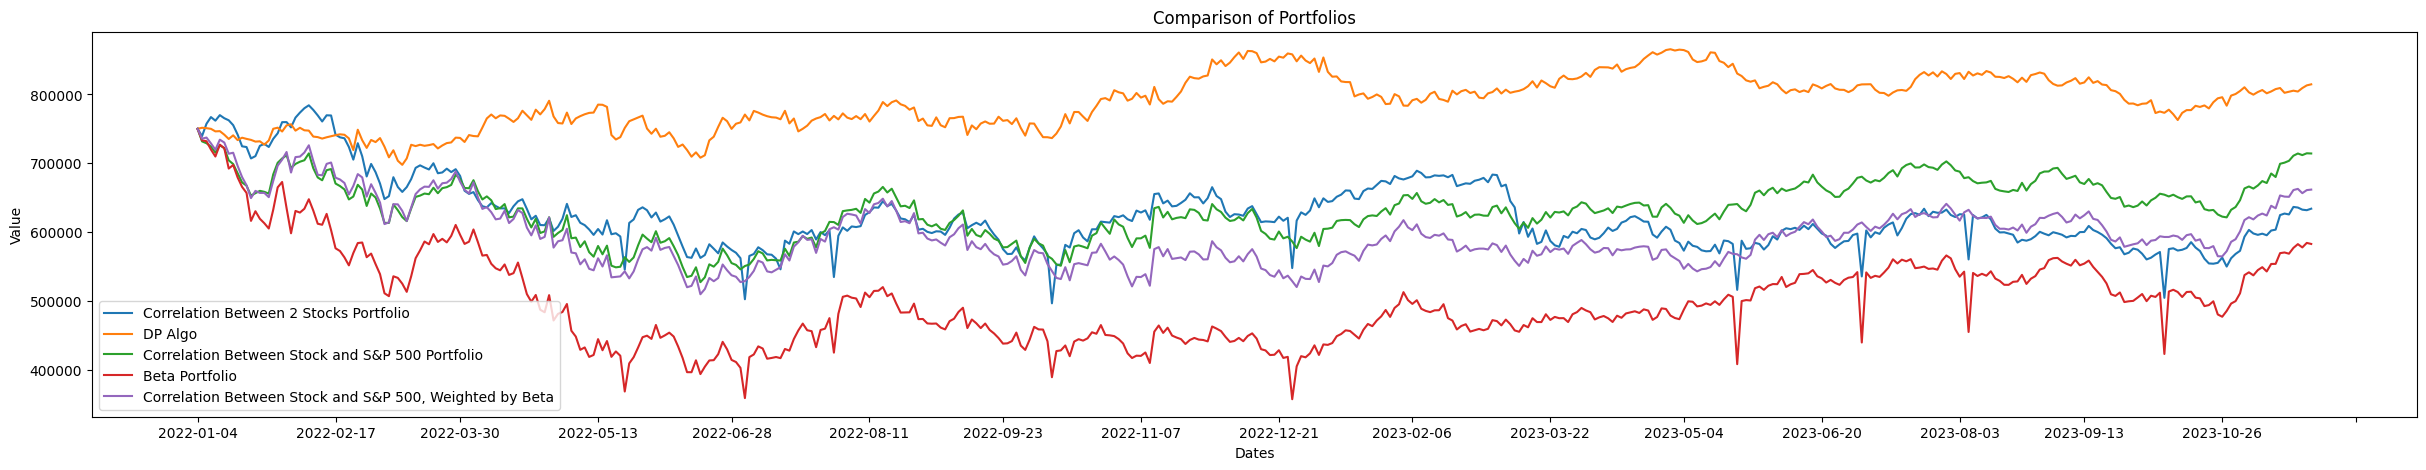

In [ ]:
# GRAPH THE PORTFOLIOS

plt.figure(figsize = (30, 5))

# STRATEGY 1
plt.plot(test_portfolio1.index, test_portfolio1['Total Value'], label='Correlation Between 2 Stocks Portfolio')

# STRATEGY 2
plt.plot(test_portfolio2.index, test_portfolio2['Total Value'], label='DP Algo')

# STRATEGY 3
plt.plot(test_portfolio3.index, test_portfolio3['Total Value'], label='Correlation Between Stock and S&P 500 Portfolio')

# STRATEGY 4
plt.plot(test_portfolio4.index, test_portfolio4['Total Value'], label = 'Beta Portfolio')

# STRATEGY 5
plt.plot(test_portfolio5.index, test_portfolio5['Total Value'], label = 'Correlation Between Stock and S&P 500, Weighted by Beta')

locator = mdate.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)

plt.title('Comparison of Portfolios')
plt.xlabel('Dates')
plt.ylabel('Value')

plt.legend()
plt.show()

In [ ]:
# STANDARD DEVIATION OF EACH PORTFOLIO'S PERCENTAGE RETURNS

portfolios = [test_portfolio1, test_portfolio2, test_portfolio3, test_portfolio4, test_portfolio5]

def get_percentage_returns(portfolio):

  # Create a dataframe with the portfolio's total value
  pct_returns = pd.DataFrame()

  pct_returns['Value'] = portfolio['Total Value']

  # Add a column for percentage returns of the total value
  pct_returns['% Returns'] = portfolio['Total Value'].pct_change()

  # Drop first row
  pct_returns.drop(index = pct_returns.index[0], inplace = True)

  std_dev_of_returns = pct_returns['% Returns'].std()

  return std_dev_of_returns

name = 0

for portfolio in portfolios:
  name += 1
  print(f'Portfolio {name}\'s standard deviation of % returns: {(get_percentage_returns(portfolio))}')

Portfolio 1's standard deviation of % returns: 0.027604819905589457
Portfolio 2's standard deviation of % returns: 0.01026615583373297
Portfolio 3's standard deviation of % returns: 0.01659374766387697
Portfolio 4's standard deviation of % returns: 0.03862560832389539
Portfolio 5's standard deviation of % returns: 0.01858073583647113


Comment on wanting high standard deviations of the percentage returns and the graph.



*   Mention how we are using std as a measure of risk
*   we want the one with the highest absolute value of std
*   beta portfolio had the highest std
*   maybe mention how besides the DP algo all the other strategies have the same 3 or 4 stocks though not sure what this means
*   the most interesting part is that the portfolio that was the most volatile did not actually account for any correlation between stocks, which seems against the spirit of what we learned. Perhaps, this is because picking only 10 stocks out of 50 is not that much (so don't have to examine asset risk against each other), or maybe we're just bad at using correlations to find the most risky stocks






##**CREATING THE FINAL PORTFOLIO**


In [ ]:
# Our final portfolio, using strategy 4
Portfolio_Final = portfolio4

# Verifying the total and sum of weights
final_portfolio_total = round(Portfolio_Final.Value.sum() + (flat_fee * num_stocks))
final_portfolio_weights = Portfolio_Final.Weight.sum()

print(f'The total value of the portfolio is ${final_portfolio_total}')
print(f'The sum of the weights is: {final_portfolio_weights}')

The total value of the portfolio is $750000
The sum of the weights is: 1.0


In [ ]:
# Display the final portfolio
display(Portfolio_Final)

,Ticker,Price,Currency,Shares,Value,Weight
1,SHOP.TO,155.223007,CAD,1207.859765,187487.625,0.25
2,AMZN,213.612338,USD,877.700357,187487.625,0.25
3,PYPL,243.728354,USD,461.548988,112492.575,0.15
4,QCOM,229.053365,USD,163.706501,37497.525,0.05
5,BLK,1112.691822,USD,33.699830,37497.525,0.05
6,AAPL,226.552331,USD,165.513746,37497.525,0.05
7,ACN,500.642443,USD,74.898814,37497.525,0.05
8,BA,272.406035,USD,137.653063,37497.525,0.05
9,AXP,215.355757,USD,174.118981,37497.525,0.05
10,TXN,229.406003,USD,163.454855,37497.525,0.05


In [ ]:
# Create the "Stock_Final" dataframe
Stocks_Final = pd.DataFrame()
Stocks_Final['Ticker'] = Portfolio_Final['Ticker']
Stocks_Final['Shares'] = Portfolio_Final['Shares']

In [ ]:
# Output the final stocks and the number of shares to a CSV
Stocks_Final.to_csv("Stocks_Group_7.csv")


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Ashton

Bodhana

Johnson